In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
#%%
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
import os
import imageio
from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

MAIN_PATH = '/content/gdrive/MyDrive/topic3_temperature/'
FILENAME = MAIN_PATH+'dataset/daily_temperature_1000_cities_1980_2020.csv'
city_data = pd.read_csv(FILENAME,nrows=12)
temp_data = pd.read_csv(FILENAME, skiprows=12)
len_city = len(temp_data.columns)-1

In [4]:
# get cities
def build_city_lookup():
    """
    First 12 rows contain information about cities and no temperture data.
    Extract the rows and transform into useful lookup table
    """
    city_lookup = city_data.T
    city_lookup.columns = city_lookup.iloc[0]
    city_lookup = city_lookup.iloc[1:,:]
    city_lookup["lat"] = city_lookup.lat.astype(np.float64)
    city_lookup["lng"] = city_lookup.lng.astype(np.float64)
    city_lookup["datetime"] = city_lookup.datetime.astype(np.int64)
    return city_lookup
build_city_lookup()
#%%
def build_reduced_city_lookup():
    """
    Convert city_lookup types and assert data is valid
    """
    city_lookup = build_city_lookup()

    # First 12 rows are information about the cities
    city_lookup = build_city_lookup()
    city_lookup = city_lookup[["city","country", "lat", "lng","datetime"]]
    # city_lookup['location']=city_lookup['city']+'-'+city_lookup['country']
    city_lookup.rename(columns={"datetime":"city_col"},inplace=True)

    # city_lookup.loc[:,"population"] = city_lookup.population.fillna(0).astype(float).astype(np.uint)

    assert len(city_lookup) == len(city_lookup.drop_duplicates())
    non_null = city_lookup[["city", "lat", "lng"]]
    assert len(non_null[non_null.isnull().T.any()]) == 0, non_null[non_null.isnull().T.any()]

    assert city_lookup.loc[(city_lookup.lat < -90) | (city_lookup.lat > 90), "lat"].count() == 0
    assert city_lookup.loc[(city_lookup.lng < -180) | (city_lookup.lng > 180), "lng"].count() == 0

    return city_lookup

city_lookup = build_reduced_city_lookup()
print(city_lookup.info())
print(city_lookup)

Unnamed: 0,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,datetime
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764,0
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016,1
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881,2
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629,3
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519,4
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Yangzhou,Yangzhou,32.4000,119.4300,China,CN,CHN,Jiangsu,NaN,539715.0,1156818601,995
996,Novokuznetsk,Novokuznetsk,53.7500,87.1150,Russia,RU,RUS,Kemerovskaya Oblast’,NaN,539616.0,1643628717,996
997,Latakia,Latakia,35.5400,35.7800,Syria,SY,SYR,Al Lādhiqīyah,admin,539147.0,1760555544,997
998,Heroica Matamoros,Heroica Matamoros,25.8800,-97.5000,Mexico,MX,MEX,Tamaulipas,minor,538785.0,1484614906,998


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      1000 non-null   object 
 1   country   1000 non-null   object 
 2   lat       1000 non-null   float64
 3   lng       1000 non-null   float64
 4   city_col  1000 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 46.9+ KB
None
Unnamed: 0               city        country      lat       lng  city_col
0                       Tokyo          Japan  35.6850  139.7514         0
1                    New York  United States  40.6943  -73.9249         1
2                 Mexico City         Mexico  19.4424  -99.1310         2
3                      Mumbai          India  19.0170   72.8570         3
4                   São Paulo         Brazil -23.5587  -46.6250         4
..                        ...            ...      ...       ...       ...
995                  Yangzhou          Ch

In [5]:
city_lookup[['city','country']].value_counts()

city        country      
Yichun      China            2
Vila Velha  Brazil           2
Suzhou      China            2
Xiping      China            2
Natal       Brazil           2
                            ..
Hartford    United States    1
Havana      Cuba             1
Hechi       China            1
Hefei       China            1
Ōsaka       Japan            1
Length: 995, dtype: int64

In [6]:
# %%
# get temperature

def city_by_name(city_name:str):
    """Lookup col of city and call city_by_index"""
    city_lookup= build_reduced_city_lookup()
    data_city  = city_lookup[city_lookup["city"]==city_name]
    city_index = int(data_city.index[0])
    return city_by_index(city_index)

def city_by_index(city_col:int):
    """Read only one col from the csv that contains the city we are interested in and city col"""
    city_lookup=build_reduced_city_lookup()
    data_city = city_lookup[city_lookup['city_col']==city_col]
    temp_city = temp_data.iloc[:,[0,city_col+1]]
    temp_city['city_col']=city_col
    temp_city.columns=['datetime','temp','city_col']
    return temp_city,data_city
print(city_by_index(2))
print()
print(city_by_name('London'))


(         datetime   temp  city_col
0      1980-01-01  11.35         2
1      1980-01-02  10.01         2
2      1980-01-03   9.67         2
3      1980-01-04  10.12         2
4      1980-01-05  10.81         2
...           ...    ...       ...
14879  2020-09-26  15.86         2
14880  2020-09-27  16.93         2
14881  2020-09-28  13.58         2
14882  2020-09-29  11.50         2
14883  2020-09-30  15.58         2

[14884 rows x 3 columns], Unnamed: 0         city country      lat     lng  city_col
2           Mexico City  Mexico  19.4424 -99.131         2)

(         datetime   temp  city_col
0      1980-01-01  -1.68        25
1      1980-01-02  -1.99        25
2      1980-01-03   2.18        25
3      1980-01-04   6.96        25
4      1980-01-05   4.14        25
...           ...    ...       ...
14879  2020-09-26   9.75        25
14880  2020-09-27  11.44        25
14881  2020-09-28  12.64        25
14882  2020-09-29  14.38        25
14883  2020-09-30  13.32        25

[14884 row

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [8]:
# merge data temp and city
# data temperature 
print('\n____________________________________ Dataframe temperature ____________________________________')
temp =pd.concat([city_by_index(x)[0] for x in range(0,len_city)])
print(temp.head())
print(temp.shape)


# raw data for machine learning
raw_data = city_lookup.merge(temp,on='city_col')

raw_data['datetime']=pd.to_datetime(raw_data['datetime'],
        format='%Y-%m-%d', errors = 'coerce')
raw_data['datetime_year']=raw_data['datetime'].dt.year
raw_data['datetime_month']=raw_data['datetime'].dt.month
raw_data['datetime_day']=raw_data['datetime'].dt.day
raw_data.drop(columns=["datetime",'city_col'],inplace=True)


# %%
# overall again
print('\n____________________________________ Dataset info ____________________________________')
print(raw_data.info()) 
print('\n____________________________________ Data after format ____________________________________')
print(raw_data.head(6))  
print('\n____________________________________ Counts on a feature ____________________________________')
print(raw_data['city'].value_counts())
print('\n____________________________________ Describe feature ____________________________________')
raw_data.describe()


____________________________________ Dataframe temperature ____________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


     datetime  temp  city_col
0  1980-01-01  4.16         0
1  1980-01-02  4.06         0
2  1980-01-03  7.12         0
3  1980-01-04  9.23         0
4  1980-01-05  3.20         0
(14884000, 3)

____________________________________ Dataset info ____________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14884000 entries, 0 to 14883999
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   city            object 
 1   country         object 
 2   lat             float64
 3   lng             float64
 4   temp            float64
 5   datetime_year   int64  
 6   datetime_month  int64  
 7   datetime_day    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 1022.0+ MB
None

____________________________________ Data after format ____________________________________
    city country     lat       lng  temp  datetime_year  datetime_month  \
0  Tokyo   Japan  35.685  139.7514  4.16           1980               1   
1

,lat,lng,temp,datetime_year,datetime_month,datetime_day
count,1.488400e+07,1.488400e+07,1.488400e+07,1.488400e+07,1.488400e+07,1.488400e+07
mean,2.420443e+01,3.592249e+01,1.817745e+01,1.999876e+03,6.495028e+00,1.572964e+01
std,2.135150e+01,7.652986e+01,9.958550e+00,1.176403e+01,3.440736e+00,8.800035e+00
min,-4.130000e+01,-1.752206e+02,-4.534000e+01,1.980000e+03,1.000000e+00,1.000000e+00
25%,1.228260e+01,-5.869525e+00,1.227000e+01,1.990000e+03,4.000000e+00,8.000000e+00
50%,3.003000e+01,4.297650e+01,2.063000e+01,2.000000e+03,7.000000e+00,1.600000e+01
75%,3.879203e+01,1.084787e+02,2.591000e+01,2.010000e+03,9.000000e+00,2.300000e+01
max,6.415000e+01,1.792166e+02,4.470000e+01,2.020000e+03,1.200000e+01,3.100000e+01


                         lat           lng      temp  datetime_year  \
lat             1.000000e+00  9.328629e-02 -0.420483   6.525765e-13   
lng             9.328629e-02  1.000000e+00 -0.006004  -1.592920e-13   
temp           -4.204829e-01 -6.003919e-03  1.000000   3.988375e-02   
datetime_year   6.525765e-13 -1.592920e-13  0.039884   1.000000e+00   
datetime_month  6.442664e-16  2.852545e-15  0.110669  -1.375887e-02   
datetime_day   -3.892225e-16  1.214956e-15  0.003861  -1.281486e-04   

                datetime_month  datetime_day  
lat               6.442664e-16 -3.892225e-16  
lng               2.852545e-15  1.214956e-15  
temp              1.106691e-01  3.861172e-03  
datetime_year    -1.375887e-02 -1.281486e-04  
datetime_month    1.000000e+00  1.041345e-02  
datetime_day      1.041345e-02  1.000000e+00  
__________sort corrmatrix__________
temp              1.000000
datetime_month    0.110669
datetime_year     0.039884
datetime_day      0.003861
lng              -0.006004
la

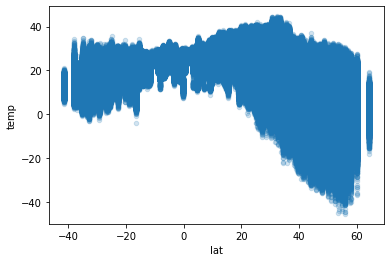

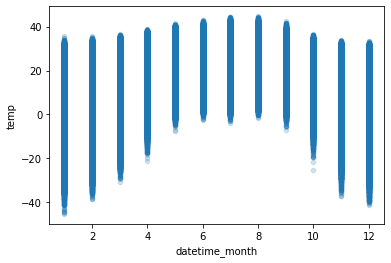

In [14]:
# 1.3 Compute correlations b/w features
corr_matrix = raw_data.corr()
print(corr_matrix) # print correlation matrix
print('__________sort corrmatrix__________')
print(corr_matrix["temp"].sort_values(ascending=False)) # print correlation b/w a feature and other features

# 1.4 Scatter plot b/w 2 features
if 1:
    raw_data.plot(kind="scatter", y="temp", x="lat", alpha=0.2)
    #plt.axis([0, 5, 0, 10000])
    #plt.savefig('figures/scatter_2_feat.png', format='png', dpi=300)
    plt.show()
if 1:
    raw_data.plot(kind="scatter", y="temp", x="datetime_month", alpha=0.2)
    #plt.axis([0, 5, 0, 10000])
    #plt.savefig('figures/scatter_1_feat.png', format='png', dpi=300)
    plt.show()  
    


In [10]:
#%%
# 2. Preprocess
# 2.1 Split data
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)
print('\n____________________________________ Split training an test set ____________________________________')     
print(len(train_set), "train +", len(test_set), "test examples")


# 2.2 Separate labels from data, since we do not process label values
train_set_labels = train_set["temp"].copy()
train_set = train_set.drop(columns = "temp") 
test_set_labels = test_set["temp"].copy()
test_set = test_set.drop(columns = "temp") 


# 2.3 Define name columns
num_feat_names = ['lat','lng','datetime_year','datetime_month','datetime_day']    #position: lat lng  #datetiem
cat_feat_names = []

# 2.4 Define ColumnSelector: a transformer for choosing columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values 



# 2.6 Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)), # select column
    ('imputer', SimpleImputer(missing_values=np.nan, 
        strategy="median", copy=True)), # copy=False: imputation will be done in-place 
    ('std_scaler', StandardScaler(with_mean=True, 
        with_std=True, copy=True)) # Scale features to zero mean and unit variance
    ])  

# 2.7 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline) ])  

# 2.8 Run the pipeline to process training data           
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________________________________ Processed feature values ____________________________________')
print(processed_train_set_val[[0, 1, 2],:])
print(processed_train_set_val.shape)


____________________________________ Split training an test set ____________________________________
11907200 train + 2976800 test examples

____________________________________ Processed feature values ____________________________________
[[ 0.77638002 -1.43585753  0.01036765 -0.72488718  1.62155173]
 [ 0.17906657  0.48874792 -0.07463663  1.30945731  1.62155173]
 [ 1.47747509  0.02209518 -1.34970081 -1.30612847 -1.67396992]]
(11907200, 5)


In [11]:
# %%
# 3. TRAIN AND EVALUATE MODELS 
new_training=0
# 3.1 Try LinearRegression model
# 3.1.1 Store models to files, to compare latter
#from sklearn.externals import joblib 
import joblib # new lib
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'/content/gdrive/MyDrive/topic3_temperature/models/' + model_name)
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('/content/gdrive/MyDrive/topic3_temperature/models/' + model_name)
    #print(model)
    return model
# 3.1.2 Compute R2 score and root mean squared error
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse  

In [12]:
#%% 
# 3.1 Try LinearRegression model
# Training
from sklearn.linear_model import LinearRegression
if new_training:
    model = LinearRegression() 
    model.fit(processed_train_set_val, train_set_labels)
    store_model(model,'LinearRegression')
else:
    model = load_model('LinearRegression')
print('\n____________________________________ LinearRegression ____________________________________')
# Compute R2 score and root mean squared error
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('R2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
# 3.1.3 Predict labels for some training instances
print("Input data: \n", train_set.iloc[0:9])
print("Predictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________________________________ LinearRegression ____________________________________
R2 score (on training data, best=1): 0.1918554391947419
Root Mean Square Error:  9.0
Input data: 
                 city           country      lat       lng  datetime_year  \
4011221    Manhattan     United States  40.7834  -73.9662           2000   
14147073     Bīkaner             India  28.0304   73.3299           1999   
254520        Moscow            Russia  55.7522   37.6155           1984   
5284655   Lubumbashi  Congo (Kinshasa) -11.6800   27.4800           1982   
3621985         Wuxi             China  31.5800  120.3000           1994   
5648438       Munich           Germany  48.1299   11.5750           2000   
11347314     Yingkou             China  40.6703  122.2800           1995   
5691911     Makassar         Indonesia  -5.1400  119.4320           1997   
12205248      Cúcuta          Colombia   7.9200  -72.5200           1981   

          datetime_month  datetime_day  
4011221

In [ ]:
#%% 
# 3.2 Try DecisionTreeRegressor model
# Training
from sklearn.tree import DecisionTreeRegressor
if new_training:
    model = DecisionTreeRegressor()
    model.fit(processed_train_set_val, train_set_labels)
    store_model(model,'DecisionTreeRegressor')      
else:
    model = load_model("DecisionTreeRegressor")
# Compute R2 score and root mean squared error
print('\n____________________________________ DecisionTreeRegressor ____________________________________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('R2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("Predictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________________________________ DecisionTreeRegressor ____________________________________
R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0
Predictions:  [ 12.6  20.6 -14.5  22.2   3.2   3.9  24.6  24.9  23.5]
Labels:       [12.6, 20.62, -14.49, 22.17, 3.15, 3.93, 24.55, 24.87, 23.5]


In [ ]:
#%% 
# 3.3 Try RandomForestRegressor model
# Training (NOTE: may take time if train_set is large)
from sklearn.ensemble import RandomForestRegressor
if new_training:
    model = RandomForestRegressor(n_estimators = 3, random_state=42) # n_estimators: no. of trees
    model.fit(processed_train_set_val, train_set_labels)
    store_model(model,'RandomForestRegressor')      
else:
    model = load_model("RandomForestRegressor")

# Compute R2 score and root mean squared error
print('\n____________________________________ RandomForestRegressor ____________________________________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('R2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("Predictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________________________________ RandomForestRegressor ____________________________________
R2 score (on training data, best=1): 0.9931754140901671
Root Mean Square Error:  0.8
Predictions:  [ 12.3  20.  -14.5  21.5   4.9   4.9  24.6  24.9  23.5]
Labels:       [12.6, 20.62, -14.49, 22.17, 3.15, 3.93, 24.55, 24.87, 23.5]


In [ ]:
#%%
# 3.4 Try polinomial regression model
# NOTE: polinomial regression can be treated as (multivariate) linear regression where high-degree features x1^2, x2^2, x1*x2... are seen as new features x3, x4, x5... 
# hence, to do polinomial regression, we add high-degree features to the data, then call linear regression
# 3.4.1 Training. NOTE: may take a while 
from sklearn.preprocessing import PolynomialFeatures
poly_feat_adder = PolynomialFeatures(degree = 2) # add high-degree features to the data
train_set_poly_added = poly_feat_adder.fit_transform(processed_train_set_val)
if new_training:
    model = LinearRegression()
    model.fit(train_set_poly_added, train_set_labels)
    store_model(model, model_name = "PolinomialRegression")      
else:
    model = load_model("PolinomialRegression")
# 3.4.2 Compute R2 score and root mean squared error
print('\n____________________________________ Polinomial regression ____________________________________')
r2score, rmse = r2score_and_rmse(model, train_set_poly_added, train_set_labels)
print('R2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
# 3.4.3 Predict labels for some training instances
print("Predictions: ", model.predict(train_set_poly_added[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________________________________ Polinomial regression ____________________________________
R2 score (on training data, best=1): 0.6240088766001185
Root Mean Square Error:  6.1
Predictions:  [16.6 17.7 -5.4 28.4 14.1 10.7 16.3 17.6 14.9]
Labels:       [12.6, 20.62, -14.49, 22.17, 3.15, 3.93, 24.55, 24.87, 23.5]


In [ ]:
print('\n____________________________________PREDICT WITH TEST DATA ____________________________________')

processed_test_set_val = full_pipeline.fit_transform(test_set)
# %%

if True:
    # %%
    # LinearRegression in test data
    model = load_model("LinearRegression")
    print('\n____________________________________ LinearRegression ____________________________________')
    r2score, rmse = r2score_and_rmse(model, processed_test_set_val, test_set_labels)
    print('R2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse.round(decimals=1))
    print("Predictions: ", model.predict(processed_test_set_val[0:9]).round(decimals=1))
    print("Labels:      ", list(test_set_labels[0:9].round(decimals=1)))
    
if True:
    # %%
    # SGDClassifier in test data
    model = load_model("DecisionTreeRegressor")
    print('\n____________________________________ DecisionTreeRegressor ____________________________________')
    # statistic
    r2score, rmse = r2score_and_rmse(model, processed_test_set_val, test_set_labels)
    print('R2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse.round(decimals=1))
    print("Predictions: ", model.predict(processed_test_set_val[0:9]).round(decimals=1))
    print("Labels:      ", list(test_set_labels[0:9].round(decimals=1)))
    
if True:
    # %%
    # RandomForestRegressor in test data
    model = load_model("RandomForestRegressor")
    print('\n____________________________________ RandomForestRegressor ____________________________________')
    r2score, rmse = r2score_and_rmse(model, processed_test_set_val, test_set_labels)
    print('R2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse.round(decimals=1))
    print("Predictions: ", model.predict(processed_test_set_val[0:9]).round(decimals=1))
    print("Labels:      ", list(test_set_labels[0:9].round(decimals=1)))

if True:
    # %%
    
    from sklearn.preprocessing import PolynomialFeatures
    poly_feat_adder = PolynomialFeatures(degree = 2) # add high-degree features to the data
    test_set_poly_added = poly_feat_adder.fit_transform(processed_test_set_val)
    model = load_model("PolinomialRegression")
    # 3.4.2 Compute R2 score and root mean squared error
    print('\n____________________________________ Polinomial regression ____________________________________')
    r2score, rmse = r2score_and_rmse(model, test_set_poly_added, test_set_labels)
    print('R2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse.round(decimals=1))
    # 3.4.3 Predict labels for some training instances
    print("Predictions: ", model.predict(test_set_poly_added[0:9]).round(decimals=1))
    print("Labels:      ", list(test_set_labels[0:9]))




____________________________________ LinearRegression ____________________________________
R2 score (on training data, best=1): 0.19202297933142654
Root Mean Square Error:  9.0
Predictions:  [27.8 11.9 15.7 13.8 19.2 13.2 20.2 15.3 17. ]
Labels:       [14.9, 6.6, 18.2, 12.1, 24.6, -1.2, 19.6, 10.4, 25.4]

____________________________________ DecisionTreeRegressor ____________________________________
R2 score (on training data, best=1): 0.969565779076562
Root Mean Square Error:  1.7
Predictions:  [13.9  6.8 12.7 13.8 25.6 -0.4 20.9 10.3 23.9]
Labels:       [14.9, 6.6, 18.2, 12.1, 24.6, -1.2, 19.6, 10.4, 25.4]

____________________________________ RandomForestRegressor ____________________________________
R2 score (on training data, best=1): 0.9727731892599989
Root Mean Square Error:  1.6
Predictions:  [13.5  4.9 15.6 10.7 25.9 -1.3 20.4 10.7 21.8]
Labels:       [14.9, 6.6, 18.2, 12.1, 24.6, -1.2, 19.6, 10.4, 25.4]

____________________________________ Polinomial regression ____________

In [16]:
#Visualize temperature in 40 years
# graphic

def displayChangeTemperature(temp_city, data_city,train=True):
    city_name = data_city['city'][0]
    folder_path = MAIN_PATH+"image/"+city_name 
    gifPath = folder_path+'/animated_temperature.gif'
    if(train):
      temp_city['datetime']=pd.to_datetime(temp_city['datetime'],
              format='%Y-%m-%d', errors = 'coerce')
      all_year= temp_city['datetime'].dt.year.unique()
      filenames = []

      os.makedirs(folder_path, exist_ok=True)
      for year in all_year:
          temp_city[temp_city['datetime'].dt.year == year].plot(
                  x='datetime',y='temp',title=city_name + ' '+str(year),
                  xlabel='month',ylabel ='temperature',
                  ylim=[temp_city['temp'].min(), temp_city['temp'].max()]
                  )
          file_name = folder_path+'/'+str(year) + '.png'
          filenames.append(file_name)
          plt.savefig(file_name, dpi=199)
          plt.close()
      plt.close()
      images = []
      for filename in filenames:
          images.append(imageio.imread(filename))
      imageio.mimsave(gifPath, images,duration = 0.2)
    
    return gifPath

In [27]:
temp_city, data_city = city_by_name('London')
gifPath = displayChangeTemperature(temp_city, data_city)

with open(gifPath,'rb') as f:
  Image(data=f.read(), format='png')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
temp_city, data_city = city_by_index(3)
gifPath = displayChangeTemperature(temp_city, data_city)

with open(gifPath,'rb') as f:
  Image(data=f.read(), format='png')

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# temp_city, data_city = city_by_name('Tokyo')
# gifPath = displayChangeTemperature(temp_city, data_city)

with open(gifPath,'rb') as f:
  Image(data=f.read(), format='png')

Output hidden; open in https://colab.research.google.com to view.